## Data Points
Esta seção provavelmente se refere ao carregamento e à visualização dos dados. Aqui é onde os dados são importados e explorados.

In [ ]:
# Importa as bibliotecas necessárias
!pip install torchviz
from torchviz import make_dot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import normaltest
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import RobustScaler,MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/DL_02_2024/MEU

In [ ]:
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_white = pd.read_csv('winequality-white.csv', sep=';')

In [ ]:
df_red.head()

In [ ]:
df_white.head()

In [ ]:
df_red['type'] = 'red'
df_white['type'] = 'white'

In [ ]:
df = pd.concat([df_red, df_white])
df.head()

In [ ]:
df = df.rename(columns={
    'fixed acidity': 'acidez fixa',
    'volatile acidity': 'acidez volatil',
    'citric acid': 'acido citrico',
    'residual sugar': 'acucar residual',
    'chlorides': 'cloretos',
    'free sulfur dioxide': 'dioxido de enxofre livre',
    'total sulfur dioxide': 'dioxido de enxofre total',
    'density': 'densidade',
    'pH': 'pH',
    'sulphates': 'sulfatos',
    'alcohol': 'alcool',
    'quality': 'qualidade',
    'type': 'tipo'
})

df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.describe()

In [ ]:
fig = px.box(df.drop(columns=['tipo']), title='Box plot the dataset for visualization')

fig.update_layout(
    xaxis_tickangle=45,
    template='plotly_white'
)

fig.show()

## Pré-processamento

- **Tratamento de Dados**: Remoção de valores.

- **Normalização/Padronização**: Uso de `RobustScaler` para normalizar as variáveis, tornando o modelo mais robusto a outliers e melhorando a eficiência do treinamento.


In [ ]:
df = df[df['dioxido de enxofre total'] < 400]
df = df[df['dioxido de enxofre livre'] < 280]
df = df[df['acucar residual'] < 60]

In [ ]:
df_dummies = pd.get_dummies(df, columns=['tipo', 'qualidade'])
df_dummies.head()

In [ ]:
df_dummies = df_dummies.replace(True, 1)
df_dummies = df_dummies.replace(False, 0)
df_dummies.head()

In [ ]:
caracteristicas = df_dummies

# Normalizando as características
scaler_minmax = MinMaxScaler()
caracteristicas_normalizadas = scaler_minmax.fit_transform(caracteristicas)

# Convertendo de volta para DataFrame
df_normalizado = pd.DataFrame(caracteristicas_normalizadas, columns=caracteristicas.columns)

# Calculando a nota como a média das características normalizadas
df_normalizado['nota'] = df_normalizado.mean(axis=1)

# Reescalonando a nota para o intervalo de 0 a 5
df_normalizado['nota_escala_0_5'] = df_normalizado['nota'] * 10

# Mostrando as notas finais
print(df_normalizado[['nota_escala_0_5']])

In [ ]:
df_normalizado = pd.to_numeric(df_normalizado['nota_escala_0_5'], errors='coerce')
df_dummies['nota'] = df_normalizado
df_dummies.head()

In [ ]:
# Assuming df_dummies is already defined and preprocessed
for col in df_dummies.columns:
    if df_dummies[col].dtype == 'object':
        try:
            df_dummies[col] = pd.to_numeric(df_dummies[col], errors='coerce')
        except:
            pass

correlation_matrix = np.corrcoef(df_dummies.T)

fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix,
    x=df_dummies.columns,
    y=df_dummies.columns,
    colorscale='hot',  # Use the named colorscale directly
    zmin=-1,
    zmax=1
))

fig.update_layout(
    title='Mapa de correlação',
    xaxis_nticks=36,
    yaxis_nticks=36,
    xaxis=dict(tickangle=90)
)

fig.show()

In [ ]:
print("Num de linhas: ", df_dummies.shape[0])
print("Num de colunas: ", df_dummies.shape[1])

In [ ]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_dummies.drop(columns=['nota']))#,'tipo_red','tipo_white'
df_scaled = pd.DataFrame(df_scaled, columns=df_dummies.drop(columns=['nota']).columns)
df_scaled.head()

In [ ]:
df_dummies = df_dummies.reset_index(drop=True)
df_scaled['nota'] = df_dummies['nota']

df_scaled.head()

In [ ]:
inertia = []

for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

df_inertia = pd.DataFrame({'Número de Clusters (k)': range(1, 7), 'Inércia': inertia})

fig = px.line(df_inertia, x='Número de Clusters (k)', y='Inércia', markers=True, title='Determinação do Número de Clusters')
fig.update_layout(xaxis_title='Número de Clusters (k)', yaxis_title='Inércia', template='plotly_white')
fig.show()

In [ ]:
kmeans_best = KMeans(n_clusters=3, random_state=42)
clusters = kmeans_best.fit_predict(df_scaled)
df_cluster = df_scaled.copy()
df_cluster['cluster'] = np.array(clusters, dtype='float64')

print(df_cluster['cluster'].value_counts())

In [ ]:
df_cluster.head()

In [ ]:
df_cluster = pd.get_dummies(df_cluster, columns=['cluster'])
df_cluster['cluster_0.0'] = df_cluster['cluster_0.0'].astype('int')
df_cluster['cluster_1.0'] = df_cluster['cluster_1.0'].astype('int')
df_cluster['cluster_2.0'] = df_cluster['cluster_2.0'].astype('int')
df_cluster.head()

In [ ]:
df_cluster['cluster_0.0'] = scaler.fit_transform(df_cluster['cluster_0.0'].values.reshape(-1, 1))
df_cluster['cluster_1.0'] = scaler.fit_transform(df_cluster['cluster_1.0'].values.reshape(-1, 1))
df_cluster['cluster_2.0'] = scaler.fit_transform(df_cluster['cluster_2.0'].values.reshape(-1, 1))

X = df_cluster.drop(columns=['nota'])
y = df_cluster['nota'].astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Treino Raw

- **Divisão de Dados**: Separação dos dados em conjuntos de treinamento e teste usando `train_test_split` do `scikit-learn`.

- **Definição do Modelo**: Criação de um modelo inicial, como regressão linear ou rede neural básica.

In [ ]:
# Converter para tensores do PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Criar DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
class RegressaoLinear(nn.Module):
    def __init__(self, input_dim):
        super(RegressaoLinear, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

def train_model(model, train_loader, criterion, optimizer, num_epochs, augmentation_fn=None):
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        mse = mean_squared_error(y_test_tensor.numpy(), outputs.numpy())
        r2 = r2_score(y_test_tensor.numpy(), outputs.numpy())
    return mse, r2

def manual_hyperparameter_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_params = None
    best_model = None

    learning_rates = [1e-3]
    num_epochs_list = [700]

    for lr in learning_rates:
        for num_epochs in num_epochs_list:
            print(f'Testando lr={lr}, num_epochs={num_epochs}')
            model = RegressaoLinear(X_train_tensor.shape[1])
            criterion = nn.MSELoss()
            optimizer = optim.SGD(model.parameters(), lr=lr)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

            train_model(model, train_loader, criterion, optimizer, num_epochs)

            mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor)
            print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

            if mse > best_mse or r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_params = (lr, num_epochs)
                best_model = model

    return best_model, best_params, best_mse, best_r2

best_model, best_params, best_mse, best_r2 = manual_hyperparameter_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

print(f'Melhores hiperparâmetros: lr={best_params[0]}, num_epochs={best_params[1]}')
print(f'Melhor MSE: {best_mse:.4f}')
print(f'Melhor R²: {best_r2:.4f}')

## Treino com Augmentation

- **Repetição do Treinamento com Dados Aumentados**: Treinamento do modelo usando o conjunto de dados aumentado para melhorar a capacidade de generalização.
  

In [ ]:
def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    noise = torch.randn(tensor.size()) * std + mean
    return tensor + noise

class RegressaoLinear(nn.Module):
    def __init__(self, input_dim):
        super(RegressaoLinear, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

def train_model(model, train_loader, criterion, optimizer, num_epochs, augmentation_fn=None):
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            if augmentation_fn:
                inputs = augmentation_fn(inputs)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        mse = mean_squared_error(y_test_tensor.numpy(), outputs.numpy())
        r2 = r2_score(y_test_tensor.numpy(), outputs.numpy())
    return mse, r2

def manual_hyperparameter_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_params = None
    best_model = None

    learning_rates = [1e-3]
    num_epochs_list = [700]

    for lr in learning_rates:
        for num_epochs in num_epochs_list:
            print(f'Testando lr={lr}, num_epochs={num_epochs}')
            model = RegressaoLinear(X_train_tensor.shape[1])
            criterion = nn.MSELoss()
            optimizer = optim.SGD(model.parameters(), lr=lr)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

            train_model(model, train_loader, criterion, optimizer, num_epochs, augmentation_fn=add_gaussian_noise)

            mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor)
            print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

            if mse > best_mse or r2 > best_r2:
                best_mse = mse
                best_r2 = r2
                best_params = (lr, num_epochs)
                best_model = model

    return best_model, best_params, best_mse, best_r2

best_model, best_params, best_mse, best_r2 = manual_hyperparameter_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

print(f'Melhores hiperparâmetros: lr={best_params[0]}, num_epochs={best_params[1]}')
print(f'Melhor MSE: {best_mse:.4f}')
print(f'Melhor R²: {best_r2:.4f}')

## Fine Tuning

- **Ajuste Fino do Modelo Pré-treinado**: Ajuste de um modelo que já foi treinado em outro conjunto de dados, aplicando o conhecimento aprendido para ajustar melhor o modelo para o conjunto de dados atual.

- **Congelamento e Descongelamento de Camadas**: Congelar camadas iniciais de uma rede neural para preservar características gerais enquanto se ajusta as camadas superiores para tarefas específicas.


In [ ]:
'''def add_gaussian_noise(tensor, mean=0.0, std=0.01):
    noise = torch.randn(tensor.size()) * std + mean
    return tensor + noise

class RegressaoLinear(nn.Module):
    def __init__(self, input_dim):
        super(RegressaoLinear, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(p=0.2)  # Adding dropout

    def forward(self, x):
        x = self.dropout(x)
        return self.linear(x)

def train_model(model, train_loader, criterion, optimizer, num_epochs, augmentation_fn=None):
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            if augmentation_fn:
                inputs = augmentation_fn(inputs)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        mse = mean_squared_error(y_test_tensor.numpy(), outputs.numpy())
        r2 = r2_score(y_test_tensor.numpy(), outputs.numpy())
    return mse, r2

def manual_hyperparameter_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_params = None
    best_model = None

    learning_rates = [1e-3]
    num_epochs_list = [700]
    batch_sizes = [16, 32, 64]
    optimizers = [optim.SGD, optim.Adam]

    for lr in learning_rates:
        for num_epochs in num_epochs_list:
            for batch_size in batch_sizes:
                for opt in optimizers:
                    print(f'Testando lr={lr}, num_epochs={num_epochs}, batch_size={batch_size}, optimizer={opt.__name__}')
                    model = RegressaoLinear(X_train_tensor.shape[1])
                    criterion = nn.MSELoss()
                    optimizer = opt(model.parameters(), lr=lr)

                    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
                    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

                    train_model(model, train_loader, criterion, optimizer, num_epochs, augmentation_fn=add_gaussian_noise)

                    mse, r2 = evaluate_model(model, X_test_tensor, y_test_tensor)
                    print(f'MSE: {mse:.4f}, R²: {r2:.4f}')

                    if mse < best_mse or r2 > best_r2:
                        best_mse = mse
                        best_r2 = r2
                        best_params = (lr, num_epochs, batch_size, opt.__name__)
                        best_model = model

    return best_model, best_params, best_mse, best_r2

# Assuming X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor are defined
best_model, best_params, best_mse, best_r2 = manual_hyperparameter_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

print(f'Melhores hiperparâmetros: lr={best_params[0]}, num_epochs={best_params[1]}, batch_size={best_params[2]}, optimizer={best_params[3]}')
print(f'Melhor MSE: {best_mse:.4f}')
print(f'Melhor R²: {best_r2:.4f}')'''

## Model Refactory

- **Otimização da Arquitetura do Modelo**: Refinamento da arquitetura do modelo, como adicionar/remover camadas, mudar funções de ativação ou ajustar a taxa de dropout.

- **Melhoria da Eficiência Computacional**: Implementação de técnicas de otimização para reduzir o tempo de treinamento e o uso de memória.

- **Refatoração do Código**: Simplificação e modularização do código para torná-lo mais limpo, eficiente e fácil de manter.

In [ ]:
# Definindo a nova arquitetura de rede neural
class WineQualityModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super(WineQualityModel, self).__init__()

        # Camada de entrada
        self.fc1 = nn.Linear(input_size, int(hidden_size))

        # Adicionando uma camada escondida com uma função de ativação ReLU
        self.fc2 = nn.Linear(int(hidden_size), int(hidden_size))

        # Camada de entrada
        self.fc3 = nn.Linear(int(hidden_size), int(hidden_size))

        # Adicionando uma camada escondida com uma função de ativação ReLU
        self.fc4 = nn.Linear(int(hidden_size), int(hidden_size))

        # Camada de entrada
        self.fc5 = nn.Linear(int(hidden_size), hidden_size)

        # Adicionando uma camada escondida com uma função de ativação ReLU
        self.fc6 = nn.Linear(hidden_size, hidden_size)

        # Camada de entrada
        self.fc7 = nn.Linear(hidden_size, hidden_size)

        # Adicionando uma camada escondida com uma função de ativação ReLU
        self.fc8 = nn.Linear(int(hidden_size), int(hidden_size/1.5))

        # Camada de entrada
        self.fc9 = nn.Linear(int(hidden_size/1.5), int(hidden_size/2))

        # Adicionando uma camada escondida com uma função de ativação ReLU
        self.fc10 = nn.Linear(int(hidden_size/2), int(hidden_size/3))

        # Camada de saída
        self.fc11 = nn.Linear(int(hidden_size/3), output_size)

        # Dropout para regularização
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Forward pass com dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = F.relu(self.fc6(x))
        x = self.dropout(x)
        x = F.relu(self.fc7(x))
        x = self.dropout(x)
        x = F.relu(self.fc8(x))
        x = self.dropout(x)
        x = F.relu(self.fc9(x))
        x = self.dropout(x)
        x = F.relu(self.fc10(x))
        x = self.dropout(x)
        x = self.fc11(x)
        return x

# Parâmetros do modelo
input_size = X_train.shape[1]  # Exemplo de número de características
hidden_size = 69
output_size = 1
dropout_rate = 0.5
num_epochs = 2000

# Instanciando o modelo
model = WineQualityModel(input_size, hidden_size, output_size, dropout_rate)
print(model)

In [ ]:
# Supondo que 'model' seja o seu modelo definido
x = torch.zeros(1, X_train.shape[1])  # Crie um tensor de entrada de exemplo
y = model(x)

# Gere o gráfico da rede neural
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("wine_quality_model", format="png")  # Salve o gráfico como um arquivo PNG

In [ ]:
# Definindo otimizador
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Utilizando GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Exemplo de loop de treinamento otimizado
for epoch in range(num_epochs):
    model.train()  # Modo de treino
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        outputs = model(X_batch)

        # Cálculo da perda
        loss = criterion(outputs, y_batch)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 0.0428
Epoch [200/2000], Loss: 0.0434
Epoch [300/2000], Loss: 0.0274
Epoch [400/2000], Loss: 0.0576
Epoch [500/2000], Loss: 0.0258
Epoch [600/2000], Loss: 0.0233
Epoch [700/2000], Loss: 0.0295
Epoch [800/2000], Loss: 0.0766
Epoch [900/2000], Loss: 0.0081
Epoch [1000/2000], Loss: 0.0637
Epoch [1100/2000], Loss: 0.0491
Epoch [1200/2000], Loss: 0.0381
Epoch [1300/2000], Loss: 0.0660
Epoch [1400/2000], Loss: 0.0261
Epoch [1500/2000], Loss: 0.0337
Epoch [1600/2000], Loss: 0.0147
Epoch [1700/2000], Loss: 0.0681
Epoch [1800/2000], Loss: 0.0511
Epoch [1900/2000], Loss: 0.0177
Epoch [2000/2000], Loss: 0.0761


In [ ]:
# Função para treinamento
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch+1) % 100 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()

    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Move tensors to CPU before converting to NumPy arrays
            r2 = r2_score(y_batch.cpu().numpy(), outputs.cpu().numpy())
            mse = mean_squared_error(y_batch.cpu().numpy(), outputs.cpu().numpy())
            total_loss += loss.item()

    if (epoch+1) % 100 == 0:
        print(r2)
        print(mse)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Exemplo de uso das funções de treinamento e avaliação
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch [100/2000], Loss: 0.0348
Epoch [200/2000], Loss: 0.0349
Epoch [300/2000], Loss: 0.0348
Epoch [400/2000], Loss: 0.0348
Epoch [500/2000], Loss: 0.0348
Epoch [600/2000], Loss: 0.0348
Epoch [700/2000], Loss: 0.0348
Epoch [800/2000], Loss: 0.0349
Epoch [900/2000], Loss: 0.0348
Epoch [1000/2000], Loss: 0.0348
Epoch [1100/2000], Loss: 0.0348
Epoch [1200/2000], Loss: 0.0348
Epoch [1300/2000], Loss: 0.0348
Epoch [1400/2000], Loss: 0.0350
Epoch [1500/2000], Loss: 0.0349
Epoch [1600/2000], Loss: 0.0347
Epoch [1700/2000], Loss: 0.0348
Epoch [1800/2000], Loss: 0.0348
Epoch [1900/2000], Loss: 0.0349
Epoch [2000/2000], Loss: 0.0348


In [ ]:
y_pred = model(X_test_tensor).detach().numpy()
y_test1 = np.reshape(y_test, (-1,))
y_pred = np.reshape(y_pred, (-1,))
df_pred = pd.DataFrame({'Actual': y_test1, 'Predicted': y_pred})

# Sample data for visualization
df_pred_sample = df_pred.sample(35, random_state=42)
df_pred_index = df_pred_sample.index.astype(str)

# Bar plot for Actual values
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=df_pred_index,
        x=df_pred_sample['Actual'],
        orientation='h',
        marker=dict(color='#9B9A9C', opacity=0.6),
        name='Reais',
        width=0.5
    )
)

# Bar plot for Predicted values
fig.add_trace(
    go.Bar(
        y=df_pred_index,
        x=df_pred_sample['Predicted'],
        orientation='h',
        marker=dict(color='#EE6C4D'),
        name='Previstos',
        width=0.25
    )
)

# Update layout to match the styling and appearance of your Matplotlib plot
fig.update_layout(
    title={
        'text': "Amostra de Valores Reais vs. Previstos",
        'font': {
            'size': 20,  # Replace 'weight' with 'size' or another valid property
            'color': 'black',
            'family': 'Arial'
        }
    }
)

# Remove grid lines from y-axis and customize grid for x-axis
fig.update_xaxes(showgrid=True, gridcolor='#9B9A9C', gridwidth=0.5, griddash='dot')
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()

In [ ]:
# Compute Residuals
df_pred['Residuals'] = abs(df_pred['Actual']) - abs(df_pred['Predicted'])

# Normality test p-value
p_value_thresh = 0.05
p_value = normaltest(df_pred['Residuals'])[1]

# Calculate mean and median of residuals
resd_mean = df_pred['Residuals'].mean()
resd_median = df_pred['Residuals'].median()

# Creating the histogram with Plotly
fig = go.Figure()

# Add histogram
fig.add_trace(go.Histogram(
    x=df_pred['Residuals'],
    nbinsx=50,
    marker_color='#EE6C4D',
    opacity=0.7,
    name='Resíduos'
))

# Add mean line
fig.add_trace(go.Scatter(
    x=[resd_mean, resd_mean],
    y=[0, max(np.histogram(df_pred['Residuals'], bins=50)[0])],
    mode="lines",
    line=dict(color='#3D5A80', width=2),
    name=f"Média: {resd_mean:.2f}"
))

# Add median line
fig.add_trace(go.Scatter(
    x=[resd_median, resd_median],
    y=[0, max(np.histogram(df_pred['Residuals'], bins=50)[0])],
    mode="lines",
    line=dict(color='black', dash='dash'),
    name=f"Mediana: {resd_median:.2f}"
))

# Add annotations for mean and median
fig.add_annotation(
    x=resd_mean, y=max(np.histogram(df_pred['Residuals'], bins=50)[0]),
    text=f"Média: {resd_mean:.2f}",
    showarrow=True,
    arrowhead=2,
    ax=resd_mean + 2,
    ay=max(np.histogram(df_pred['Residuals'], bins=50)[0]),
    font=dict(size=10, color='#3D5A80')
)

fig.add_annotation(
    x=resd_median, y=max(np.histogram(df_pred['Residuals'], bins=50)[0]),
    text=f"Mediana: {resd_median:.2f}",
    showarrow=True,
    arrowhead=2,
    ax=resd_median - 2,
    ay=max(np.histogram(df_pred['Residuals'], bins=50)[0]),
    font=dict(size=10, color='black')
)

# Update layout
fig.update_layout(
    title={
        'text': 'Distribuição dos Resíduos',
        'y': 0.98,
        'x': 0.12,
        'xanchor': 'left',
        'yanchor': 'top',
        'font': dict(size=12, color='#100C07', family='sans-serif')
    },
    xaxis_title='Resíduos',
    xaxis=dict(titlefont=dict(size=10, color='#100C07')),
    yaxis_title='Frequência',
    bargap=0.1,
    showlegend=True,
    legend=dict(font=dict(size=10)),
    template="plotly_white"
)

fig.show()

In [ ]:
evaluate_model(model, test_loader, criterion, device)

-0.0061136064966023085
0.03984578
Epoch [2000/2000], Loss: 0.0398


11 Camadas

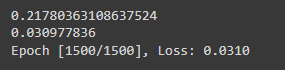

16 Camadas